In [75]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
#from skimage import transform
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import re
import xml.etree.ElementTree as ET
import cv2
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *

#from display import read_image, draw_boxes, draw_grid, draw_text
#import display

In [2]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x
define_gpu_to_use()

Chosen GPU: 0


In [3]:
def load_raw_images(root,split):
    set_of_transforms = {}
    set_of_transforms['train'] = transforms.Compose(
        [transforms.RandomRotation(30),
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    set_of_transforms['test'] = transforms.Compose(
        [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    set_of_transforms['validate'] = set_of_transforms['test']
    

    whole_dataset = torchvision.datasets.ImageFolder(root=root+'/'+split, transform=set_of_transforms[split])
    
    return whole_dataset   

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
#path_to_img_folder = '/home/u1135274/test_gpu/DeepLearningProject/color/60_20_20'
path_to_img_folder = '../color/60_20_20'
train_data = load_raw_images(path_to_img_folder,'train')
test_data = load_raw_images(path_to_img_folder,'test')
val_data = load_raw_images(path_to_img_folder,'validate')
label_names,label_indices = find_classes('../color/60_20_20/train')
label_names_dict = dict((v,k) for k,v in label_indices.items())
print (len(train_data))
print (len(test_data))
print (len(val_data))
#print (label_names)
print (label_names_dict)

16051
6453
4264
{0: 'Apple_Frogeye_Spot', 1: 'Apple___Apple_scab', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_including_sour___Powdery_mildew', 6: 'Cherry_including_sour___healthy', 7: 'Corn_maize___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_maize___Common_rust_', 9: 'Corn_maize___Northern_Leaf_Blight', 10: 'Corn_maize___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_Black_Measles', 13: 'Grape___Leaf_blight_Isariopsis_Leaf_Spot', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_Citrus_greening', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper_bell___Bacterial_spot', 19: 'Pepper_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'Tomat

In [4]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 84, num_workers = 3)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size = 84, num_workers = 3)
val_loader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = 84, num_workers = 3)
train_loader_vis = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 1, num_workers = 3)
print (len(train_loader))
print (len(test_loader))
print (len(val_loader))

192
77
51


In [5]:
def read_image(image, size):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    return img

In [6]:
def draw_boxes(image, boxes_list):
    for boxes in boxes_list:
        cv2.rectangle(image, (int(boxes[0]-boxes[2]/2),int(boxes[1]-boxes[3]/2)),(int(boxes[0]+boxes[2]/2),int(boxes[1]+boxes[3]/2)),(0,0,255),2)
    return image

In [7]:
def draw_grid(img, pixel_step):
    x = pixel_step
    y = pixel_step

    while x < img.shape[1]:
        cv2.line(img, (x, 0), (x, img.shape[0]), color=(255, 255, 255))
        x += pixel_step

    while y < img.shape[0]:
        cv2.line(img, (0, y), (img.shape[1], y), color=(255, 255, 255))
        y += pixel_step

    return img

In [8]:
def draw_text(img, text_list, location):
    for text,loc in zip(text_list, location):
        cv2.putText(img, text, (int(loc[0]), int(loc[1])), cv2.FONT_HERSHEY_COMPLEX,0.5, (255, 0, 0), 1)
    return img

In [10]:
# def img_normalize(image):
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     img = normalize(torch.from_numpy(image))
#     return img.numpy()

# def preprocess(img, min_size=600, max_size=1000):
#     C,H,W = img.shape
#     scale1 = min_size/min(H,W)
#     scale2 = max_size/max(H,W)
#     scale = min(scale1, scale2)
#     img = img/255
#     img = transform.resize(img, (C,H*scale, W*scale), mode='reflect', anti_aliasing=False)
#     normalize = img_normalize
#     return normalize(img)

In [14]:
# class CropBiggestCenteredInscribedSquare(object):
#     def __init__(self):
#         pass

#     def __call__(self, tensor):
#         longer_side = min(tensor.size)
#         horizontal_padding = (longer_side - tensor.size[0]) / 2
#         vertical_padding = (longer_side - tensor.size[1]) / 2
#         return tensor.crop(
#             (
#                 -horizontal_padding,
#                 -vertical_padding,
#                 tensor.size[0] + horizontal_padding,
#                 tensor.size[1] + vertical_padding
#             )
#         )

#     def __repr__(self):
#         return self.__class__.__name__ + '()'

In [11]:
classification_model = models.resnet152(pretrained=True)
for param in classification_model.parameters():
    param.requires_grad = False
print (classification_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [12]:
fc_layer = torch.nn.Sequential(OrderedDict([
    ('fc_layer1',torch.nn.Linear(2048, 512)),
    ('relu',torch.nn.ReLU()),
    ('fc_layer2',torch.nn.Linear(512,38)),
    ('softmax',torch.nn.LogSoftmax(dim=1))]))
classification_model.fc = fc_layer

In [14]:
def train_classification_model(data_loader, model, criterion, optimizer, lr_decay, num_epochs,mode='train'):
    for epoch in range(num_epochs):
        if mode=='train':
            #lr_decay.step()
            model.train()
        elif mode=='val':
            model.eval()
        loss_sum = []; acc = 0
        for i in data_loader:
            input_img =i[0].cuda()
            target = i[1].cuda() 
            if mode=='train':
                optimizer.zero_grad()
            #with torch.set_grad_enabled(mode=='train'):
                #print (target.shape)
            predicted_output = model(input_img)
            #print (predicted_output.shape)
            loss = criterion(predicted_output, target)
            _,pred_out = torch.max(predicted_output,1)
                
            if mode=='train':
                loss.backward()
                optimizer.step()
            loss_sum.append(loss.item())
            acc+=torch.sum(pred_out==target.data)
        epoch_loss = sum(loss_sum)/len(loss_sum)
        epoch_accuracy = acc.item()/len(train_data)
        print ("epoch:"+str(epoch))
        print ("Loss:{:.6f}".format(epoch_loss))
        print ("Accuracy:{:.6f}".format(epoch_accuracy))



In [14]:
#train
criterion = torch.nn.NLLLoss()
classification_model = classification_model.cuda()
optimizer = torch.optim.Adam(classification_model.fc.parameters(), lr=0.001)
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_classification_model(train_loader, classification_model, criterion, optimizer,lr_schedule,5,'train')

epoch:0
Loss:1.174817
Accuracy:0.693602
epoch:1
Loss:0.545806
Accuracy:0.833344
epoch:2
Loss:0.440890
Accuracy:0.867173
epoch:3
Loss:0.414703
Accuracy:0.871971
epoch:4
Loss:0.370969
Accuracy:0.883496


In [18]:
#test
def test_model(model):
    model.eval()
    accuracy_list=[]
    for i in test_loader:
        input_img=i[0].cuda()
        target=i[1].cuda()
        pred_output = model(input_img)
        eq = (target.data == torch.exp(pred_output).max(1)[1])
        #print (eq)
        accuracy_list.append(eq.type_as(torch.FloatTensor()).mean())
    print ("Test accuracy:{:.6f}".format(sum(accuracy_list)/len(accuracy_list)))


In [ ]:
test_model(classification_model)

# Visualization of the saliency map

In [16]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [17]:
def make_heatmap(image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

In [123]:
count_img=0
for i in train_loader_vis:
    #print (i[1].item())
    if (int(i[1].item())==11):
        make_saliency_map(i[0], 11)
        count_img+=1
    if (count_img>5):
        break

None


AttributeError: 'NoneType' object has no attribute 'data'

# AlexNet

In [9]:
class AlexNetModification(torch.nn.Module):
    def __init__(self):
        super(AlexNetModification, self).__init__()
        self.alex_model = models.alexnet(pretrained = True)

#         for param in self.alex_model.parameters():
#             param.requires_grad = False

#         for param in self.alex_model.features[10].parameters():
#             param.requires_grad = True
        
#         for param in self.alex_model.features[8].parameters():
#             param.requires_grad = True

#         for param in self.alex_model.features[6].parameters():
#             param.requires_grad = True

        self.modification_layer = torch.nn.Sequential(
                    torch.nn.Linear(1000, 400),
                    torch.nn.Linear(400,100),
                    torch.nn.Linear(100, 38),
                    )

        for param in self.modification_layer.parameters():
            param.requires_grad = True
            
        print (self.alex_model.parameters)
        print (self.alex_model.features[10])
        print (self.alex_model.features[8])
        print (self.alex_model.features[6])
                
    def forward(self,x):    
        out = self.alex_model.forward(x)
        out = self.modification_layer(out)
        return out
    
                
alex_net_model = AlexNetModification()

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2

In [10]:
alex_net_model

AlexNetModification(
  (alex_model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=92

In [11]:
print (alex_net_model.alex_model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [15]:
criterion = torch.nn.CrossEntropyLoss()
alex_net_model = alex_net_model.cuda()
optimizer = torch.optim.Adam(alex_net_model.parameters(), lr=0.0001)
#lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_schedule=0
train_classification_model(train_loader, alex_net_model, criterion, optimizer,lr_schedule,10,'train')

epoch:0
Loss:0.945519
Accuracy:0.734534
epoch:1
Loss:0.425787
Accuracy:0.869229
epoch:2
Loss:0.320332
Accuracy:0.901128
epoch:3
Loss:0.276304
Accuracy:0.912342
epoch:4
Loss:0.233355
Accuracy:0.927481
epoch:5
Loss:0.228917
Accuracy:0.928727
epoch:6
Loss:0.210531
Accuracy:0.934957
epoch:7
Loss:0.220006
Accuracy:0.931780
epoch:8
Loss:0.188890
Accuracy:0.941063
epoch:9
Loss:0.176703
Accuracy:0.944053


In [ ]:
#on freezing all the layers except 8,6,10, and with 2 linear additional layers got an accuracy 0.936806 (0.0001,e-5)
#on using the whole of alexnet model with three linear models - 0.945854 (0.0001,e-5)
#freezing the layers except 8,6,10 with 3 linear - 0.937061 (0.0001,e-5)
# without lr decay and 3 layers, frozen, two addn linear  0.95 (lr=0.0001,e-5)
#with 0.001 lr and no lr decay and 3 layers, frozen, two addn linear 0.8767
# with lr=0.0001 and no lr decay and 3 layers, frozen, two addn linear (e-10) - 0.96

In [19]:
test_model(alex_net_model)

Test accuracy:0.966914


# Visualization of output of various layers in alex net

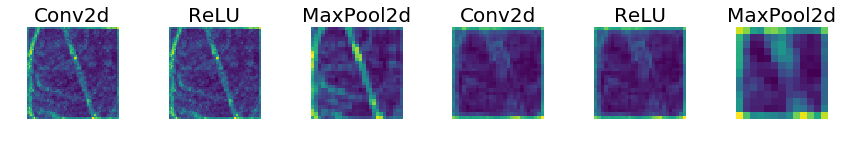

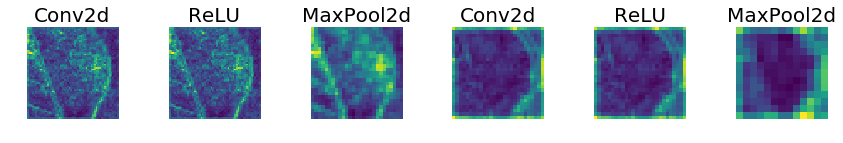

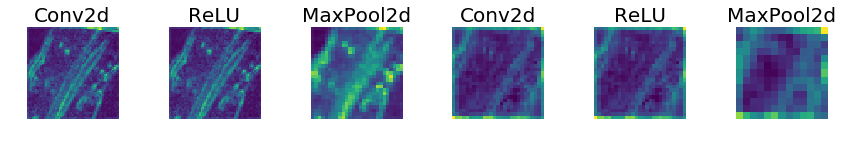

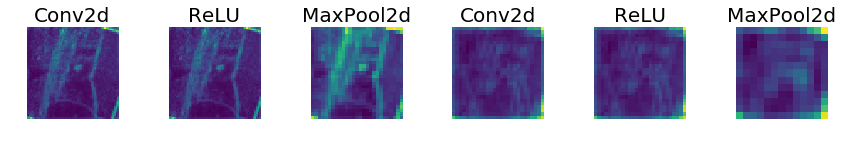

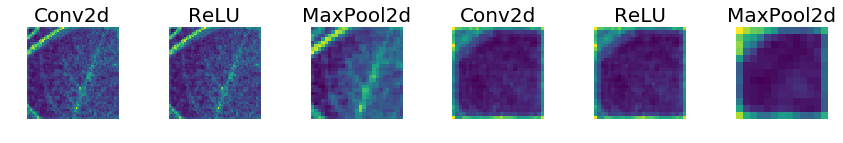

In [83]:
model_list = list(alex_net_model.alex_model.features)
#model_list = list(alex_net_model.modules())
def conversion_to_grayscale(im):

    im = torch.sum(im, dim=0)
    im = torch.div(im, im.shape[0])
    return im

def visualization_layers(img, models):
    final_vis = []
    vis_layers_names = []
    #print (models.alex_model) #['alex_model'])
    for current_layer in models[:6]:
        #print (current_layer)
        #print (img.shape)
        img = img.cuda()
        img = current_layer(img)
        final_vis.append(img)
        vis_layers_names.append(str(current_layer))
    final_images = []
    for i in final_vis:
        i = i.squeeze(0)
        grayscale_img = conversion_to_grayscale(i)
        #print (grayscale_img.shape)
        final_images.append(grayscale_img.data.cpu().numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (25, 40)


    for i in range(len(final_images)):
        a = fig.add_subplot(20,10,i+1)
        #print (final_images[i].shape)
        imgplot = plt.imshow(final_images[i])
        plt.axis('off')
        a.set_title(vis_layers_names[i].partition('(')[0], fontsize=20)

    plt.savefig('visualization_layers.jpg', bbox_inches='tight')
count_images=0    
for i in train_loader_vis: 
    count_images+=1
    if count_images>5:
        break
    #print (i[0].shape)
    visualization_layers(i[0], model_list)

In [79]:
class intermediate_activation_layer(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.intermediate_layer_models = []
        for i in range(len(self.model)):
             self.intermediate_layer_models.append(self.return_sequential(i, self.model))
                
    def return_sequential(self,number_of_layer, model):
        return torch.nn.Sequential(*list(model.children())[:number_of_layer])

    def forward(self, x):
        self.final_output = []
        for i in range(len(self.model)):
            self.final_output.append(self.intermediate_layer_models[i](x))
        return self.final_output
    
def read_image(path_to_img, resize):
    image = Image.open(path_to_img)
    image = image.resize(resize)
    image = np.array(image, dtype=np.float32)
    image = np.einsum('ijk->kij', image)
    image = image[None]
    image = torch.from_numpy(image)
    return image
    
def plot_activation(label_folder,filename, model, transformer=None, dpi=None,
total_layers=None, composite=True, individuals=True, animation=True,
composite_figsize=(96,96), animation_figsize=(12,12), resize=(224,224),
resize_animation=(256,256), animation_interval=200, folder_suffix=1,
return_acts=True):
    #import os
    scriptDir = os.path.dirname(os.path.realpath('__file__'))
    path_name = os.path.join(scriptDir, '../color/60_20_20/train/'+label_folder+'/'+filename)
    path_name = os.path.abspath(os.path.realpath(path_name))
    path = '../color/'
    #path_name = '/home/u1135274/test_gpu/color/60_20_20/train/label_folder/filename' #'../color/60_20_20/train/label_folder/filename'
    print (label_folder)
    #path_name = '/color/60_20_20/train/label_folder/filename'
    image_val = read_image(path_name,resize)
    image_val=image_val.cuda()
    model.eval()
    activation_model = intermediate_activation_layer(model)
    layer_outputs = activation_model(V(image_val))
    layer_outputs = [i for i in layer_outputs if i.dim() == 4]
    if total_layers is not None:
        layer_outputs = layer_outputs[:total_layers]
    
    for i, layer in enumerate(layer_outputs):
        print('Processing Layer: ', i)
        features = layer.data
        images = features.cpu().numpy()[0]
        number_of_images = len(images)
        number_of_rows = np.sqrt(next_square(number_of_images)).astype('int')
        if composite:
            save_composite(images, path, i, rows=number_of_rows, cols=number_of_rows,
                        figsize=composite_figsize, suffix=folder_suffix)
        if individuals:
            save_individuals(images, path, i, suffix=folder_suffix)
    if animation:
        save_animation(layer_outputs, path, figsize=animation_figsize, dpi=dpi,
                resize=resize_animation, interval = animation_interval, suffix=folder_suffix)


        
def save_animation(layer_outputs, PATH, figsize=(10,10), dpi=100, resize=(256,256),
                    interval=200, suffix=1):
    """
    This function takes a list of four dimensional activations and
    assembles them into an animation
    """
    dest = os.path.join(PATH, f'animation{suffix}/')
    os.makedirs(dest, exist_ok=True)

    if dpi:
        fig = plt.figure(figsize=figsize, dpi=dpi)
    else:
        fig = plt.figure(figsize=figsize)

    plt.axis('off')
    im_lst = []
    for i, layer in enumerate(layer_outputs):
        print('Animating Layer: ', i)
        features = layer.data
        images = features.cpu().numpy()[0]

        for j, im in enumerate(images):
            im_iter = PIL.Image.fromarray(im)
            im_iter = im_iter.resize(resize)
            im_iter = np.array(im_iter)
            im_plt = plt.imshow(im_iter, animated=True)
            im_lst.append([im_plt])
    ani = animation.ArtistAnimation(fig, im_lst, interval=interval)
    ani.save(f'{dest}cnn_animation.mp4')
    plt.close(fig)


def save_composite(ims, PATH, layer_num, rows=1, cols=None, figsize=(96,96), suffix=1):

    dest = os.path.join(PATH, f'composite{suffix}/')
    os.makedirs(dest, exist_ok=True)
    fig = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = fig.add_subplot(rows, cols, i+1)
        plt.imshow(ims[i], interpolation=None, cmap=None)
        plt.axis('off')
        plt.subplots_adjust(hspace = 0.500)

    fig.savefig(f'{dest}layer{layer_num}.jpg', bbox_inches='tight')
    plt.close(fig)


def save_individuals(ims, PATH, layer_num, suffix=1):
    dest = os.path.join(PATH, f'individuals{suffix}/')
    os.makedirs(dest, exist_ok=True)
    for j, im in enumerate(ims):
        fig = plt.figure()
        plt.imshow(im)
        plt.axis('off')
        fig.savefig(f'{dest}layer{layer_num}_image{j}.jpg', bbox_inches='tight')
        plt.close(fig)

# DenseNet

In [28]:
class dense_net_model(torch.nn.Module):
    def __init__(self, num_classes):
        super(dense_net_model,self).__init__()
        dense_net_original = models.densenet161(pretrained=True)
        self.dense_net_features = torch.nn.Sequential(*list(dense_net_original.children())[:-1])
        self.classifier = (torch.nn.Linear(2208, num_classes))

    def forward(self, x):
        x = self.dense_net_features(x)
        x = torch.nn.ReLU()
        x = F.avg_pool2d(x, kernel_size=7).view(x.size(0), -1)
        y = self.classifier(x)
        return x,y


dense_model = dense_net_model(38)

In [29]:
print (dense_model)

dense_net_model(
  (dense_net_features): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1

In [23]:
criterion = torch.nn.CrossEntropyLoss()
dense_model = dense_model.cuda()
optimizer = torch.optim.Adam(dense_model.parameters(), lr=0.0001)
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_classification_model(train_loader, dense_model, criterion, optimizer,lr_schedule,3,'train')

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 3.95 GiB total capacity; 3.47 GiB already allocated; 640.00 KiB free; 5.07 MiB cached)